# NCME 2022 Data Science Upskill Workshop - Session 4
# Accelerating Python with numba, multiprocessing, and dask
#### Questions contact: jhao@ets.org

In [28]:
from numba import jit, njit
import numpy as np
import time
import graphviz

## 1. Jit from numba

In [ ]:
def naive_sum(n):
    s = 0
    for i in range(n):
        s = i+1
    return s

# using jit. 
@jit
def naive_sum_jit(n):
    s = 0
    for i in range(n):
        s = i+1
    return s

# Note that the @jit is the decorator function. It takes another function as its argument, 
# and returns yet another function. Decorators can be extremely useful as they allow the extension of 
# an existing function, without any modification to the original function source code.
# the above function means naive_sum_jit = jit(naive_sum_jit)


# njit is the jit(nonpython=True)
@njit  
def naive_sum_njit(n):
    s = 0
    for i in range(n):
        s = i+1
    return s


In [ ]:
n = 10000000

In [ ]:
%%timeit
naive_sum(n)

In [ ]:
%%timeit 
naive_sum_jit(n)

In [ ]:
%%timeit
naive_sum_njit(n)

## 2. Universal function (ufunc) and vectorization using numba

In [ ]:
from numba import vectorize

In [ ]:
# direct loop
def naive_array_sum_loop(a,b):
    c = np.zeros(n)
    for i in range(n):
        c[i] = a[i]+b[i]
    return c

# using jit to accelerate
@njit
def naive_array_sum_njit(a,b):
    c = np.zeros(n)
    for i in range(n):
        c[i] = a[i]+b[i]
    return c

# creating ufunc using vectorize from numba
@vectorize
def naive_array_sum_ufunc(a,b):
    c = a + b
    return c

In [ ]:
a = np.arange(n)
b = np.arange(n)

In [ ]:
a

In [ ]:
b

In [ ]:
print(type(naive_array_sum_loop))
%timeit naive_array_sum_loop(a,b)

In [ ]:
print(type(naive_array_sum_njit))  
%timeit naive_array_sum_njit(a,b)

In [ ]:
print(type(naive_array_sum_ufunc))
%timeit naive_array_sum_ufunc(a,b)

## 3. Accelerating pandas with numba 

In [ ]:
import pandas as pd

In [ ]:
df = pd.DataFrame([[2, 4]] * 10000, columns=['A', 'B'])

In [ ]:
df.shape

In [ ]:
df

In [ ]:
# simple square
def get_square(x):
    return x**2

# jit version
@njit
def get_square_njit(x):
    return x**2

# ufunct using vectorize
@vectorize
def get_square_vectorize(x):
    return x**2

In [ ]:
%%time
# direct loop
for i in range(df.shape[0]):
    df.at[i,'square_A'] = get_square(df.A.iloc[i])

In [ ]:
%%time
# using apply
df['square_A'] = df.A.apply(get_square)


In [ ]:
%%time
# using apply with njit
df['square_A'] = df.A.apply(get_square_njit)

In [ ]:
%%time
# using apply with ufunc
df['square_A'] = df.A.apply(get_square_vectorize)

In [ ]:
%%time
# using vectorization
df['square_A'] = get_square(df.A)

In [ ]:
%%time
#using vectorization a different way
df['square_A'] = get_square_vectorize(df.A)

## 5. Parallelization

### 5.0 Parallelization using multiprocessing

In [34]:
from multiprocessing import Pool #package comes with python distribution
from myfunctions import slow_add 

In [19]:
#more data
data = [1, 2, 3, 4, 5, 6]

In [20]:
%%time
for x in data:
    slow_add(x,1)

CPU times: user 966 µs, sys: 1.49 ms, total: 2.46 ms
Wall time: 6.02 s


In [27]:
%%time
# multiprocessing approach
args = list(zip(data,[1]*6))
with Pool(6) as p:
    result = p.starmap(slow_add,args)

CPU times: user 17 ms, sys: 40.5 ms, total: 57.4 ms
Wall time: 1.19 s


In [24]:
result

[2, 3, 4, 5, 6, 7]

### 5.1 Parallelization using Dask delayed

In [35]:
%%time
# This takes three seconds to run because we call each

x = slow_add(1, 2)
y = slow_add(2, 3)
z = slow_add(x, y)

print("z is", z)

z is 8
CPU times: user 1.31 ms, sys: 2.14 ms, total: 3.45 ms
Wall time: 3.01 s


In [36]:
from dask import delayed

In [37]:
# make a delayed function
@delayed
def delayed_slow_add(x, y):
    time.sleep(1)
    return x + y

In [38]:
%%time
# This runs immediately, all it does is build a graph

x = delayed_slow_add(1, 2)
y = delayed_slow_add(2, 3)
z = delayed_slow_add(x, y)
z

CPU times: user 637 µs, sys: 609 µs, total: 1.25 ms
Wall time: 945 µs


Delayed('delayed_slow_add-be3915a1-cbe5-4f9e-96db-cccd3780a116')

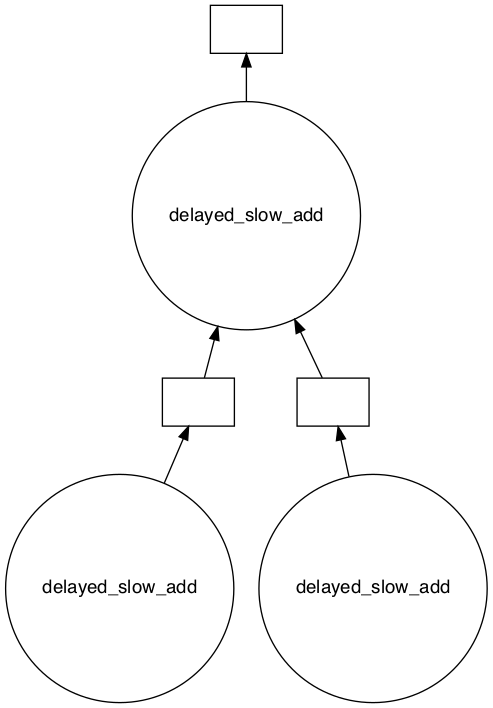

In [39]:
# visualize the task graph
z.visualize()

In [40]:
%%time
# This actually runs our computation
# using a local thread pool

z.compute()

CPU times: user 3.1 ms, sys: 3.56 ms, total: 6.66 ms
Wall time: 2.01 s


8

In [ ]:
%%time
# an alternative way to use the delayed on existing function

x = delayed(slow_add)(1, 2)
y = delayed(slow_add)(2, 3)
z = delayed(slow_add)(x, y)
z

In [ ]:
%%time
# This actually runs our computation
# using a local thread pool

z.compute()

In [ ]:
%%time
# Consider a list using convential loop

results = []

for x in data:
    y = slow_add(x, 1)
    results.append(y)
    
total = sum(results)
print("total is", total)

In [ ]:
# now let's use the delayed version

results = []

for x in data:
    y = delayed_slow_add(x, 1)
    results.append(y)
    
total = delayed(sum)(results)

# Let's see what type of thing total is
print("Printing total: ", total)

In [ ]:
total.visualize()

In [ ]:
%%time

# Compuing time
result = total.compute()
print("Printing result from computing total:", result)

In [41]:
# what if I have more processes than the number of my CPU cores?
data = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]

In [31]:
%%time
# Consider a list using convential loop

results = []

for x in data:
    y = slow_add(x, 1)
    results.append(y)
    
total = sum(results)
print("total is", total)

total is 324
CPU times: user 2.32 ms, sys: 2.62 ms, total: 4.93 ms
Wall time: 24.1 s


In [42]:
# now let's use the delayed version

results = []

for x in data:
    y = delayed_slow_add(x, 1)
    results.append(y)
    
total = delayed(sum)(results)

# Let's see what type of thing total is
print("Printing total: ", total)

Printing total:  Delayed('sum-6c2fd91f-18b0-449e-843b-86263a50dace')


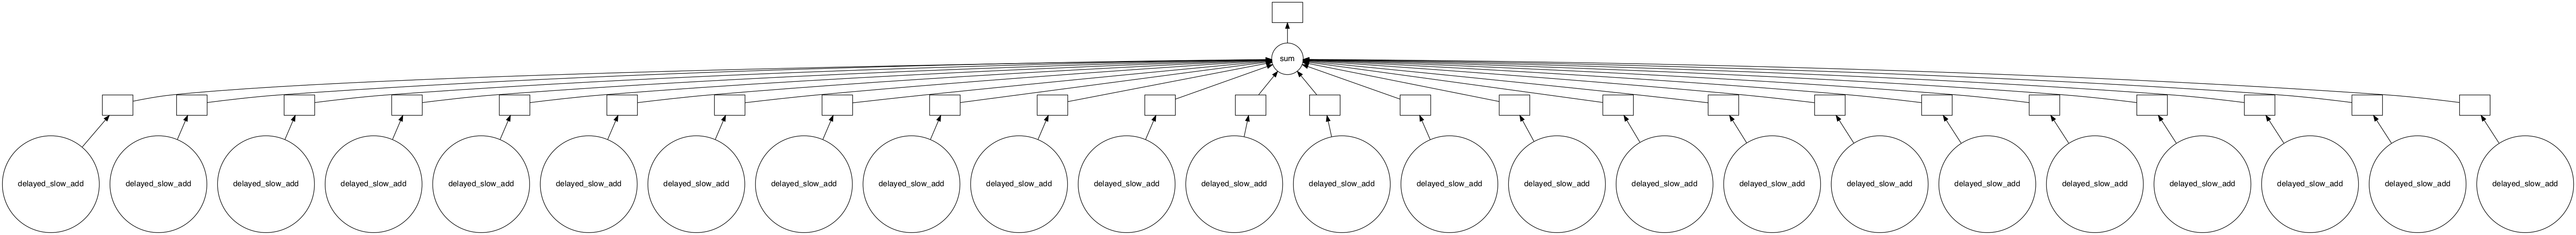

In [43]:
total.visualize()

In [44]:
%%time

# Compuing ...
result = total.compute()
print("Total:", result)

Total: 324
CPU times: user 7.5 ms, sys: 4.69 ms, total: 12.2 ms
Wall time: 2.01 s


### 5.2 Scheduling - single machine

#### 5.2.1 Multiple local processes - cores of CPU

In [45]:
# find out how many logic 
import os
os.cpu_count()

12

In [60]:
# use 12 cores
%time result = total.compute(scheduler='processes', num_workers = 6)

CPU times: user 20.9 ms, sys: 41.5 ms, total: 62.4 ms
Wall time: 6.43 s


In [47]:
#use 24 cores
%time result = total.compute(scheduler='processes', num_workers = 24)

CPU times: user 19.7 ms, sys: 38.9 ms, total: 58.6 ms
Wall time: 6.4 s


#### 5.2.2 Multiple threads

In [49]:
# Single thread ...
%time result = total.compute(scheduler='synchronous')

CPU times: user 6.32 ms, sys: 2.6 ms, total: 8.92 ms
Wall time: 24.1 s


In [50]:
# Using more threads
%time result = total.compute(scheduler='threads', num_workers=24)

CPU times: user 7.28 ms, sys: 4.67 ms, total: 11.9 ms
Wall time: 1.01 s


In [59]:
%time result = total.compute(scheduler='threads', num_workers=6)

CPU times: user 5.34 ms, sys: 3 ms, total: 8.34 ms
Wall time: 4.01 s
